# Loading Images Using tf.Data.Dataset

**Learning Objectives**

1. Retrieve Images using tf.keras.utils.get_file
2. Load Images using Keras Pre-Processing
3. Load Images using tf.Data.Dataset
4. Understand basic Methods for Training

## Introduction 

In this notebook, we load an image dataset using tf.data.  The dataset used in this example is distributed as directories of images, with one class of image per directory.


## Setup

## Load necessary libraries 
We will start by importing the necessary libraries for this lab.

In [1]:
# Importing numpy, a data processing and an image module I/O libraries
import IPython.display as display
from PIL import Image
import PIL
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import tensorflow_datasets as tfds

print("TensorFlow version: ",tf.version.VERSION)

TensorFlow version:  2.0.0


In [12]:
# It contains experimental Dataset sources and transformations that can be used in conjunction with the tf.data.Dataset
AUTOTUNE = tf.data.experimental.AUTOTUNE

### Retrieve the images

Before you start any training, you will need a set of images to teach the network about the new classes you want to recognize. You can use an archive of creative-commons licensed flower photos from Google.

Note: all images are licensed CC-BY, creators are listed in the `LICENSE.txt` file.

In [3]:
# Importing pathlib to import necessary set of images
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

After downloading (218MB), you should now have a copy of the flower photos available.

The directory contains 5 sub-directories, one per class:

In [14]:
# Print the image count
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [15]:
# Here, np.array() method creates an array
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['tulips', 'sunflowers', 'roses', 'daisy', 'dandelion'],
      dtype='<U10')

Each directory contains images of that type of flower. Here are some roses:

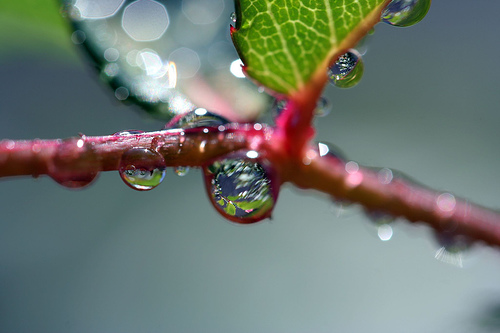

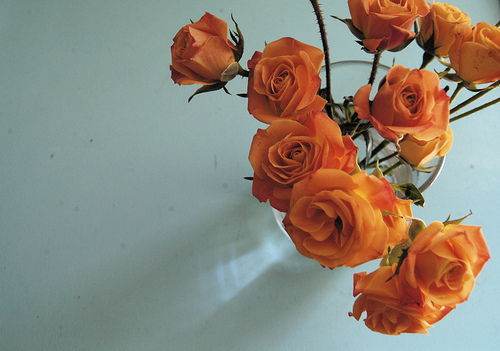

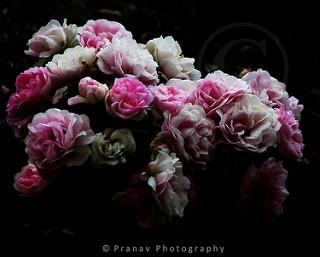

In [16]:
# Here, Image.open() method Opens and identifies the given image file.
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

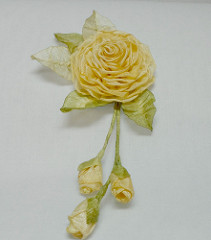

In [17]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[3]))

## Load using `keras.preprocessing`

A simple way to load images is to use `tf.keras.preprocessing`.

In [18]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 

Define some parameters for the loader:

In [19]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [20]:
# Generate batches of tensor image data with real-time data augmentation.
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


Inspect a batch:

In [21]:
# Here, define show_batch() procedure for Inspecting a batch.
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1) 
      plt.imshow(image_batch[n]) 
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

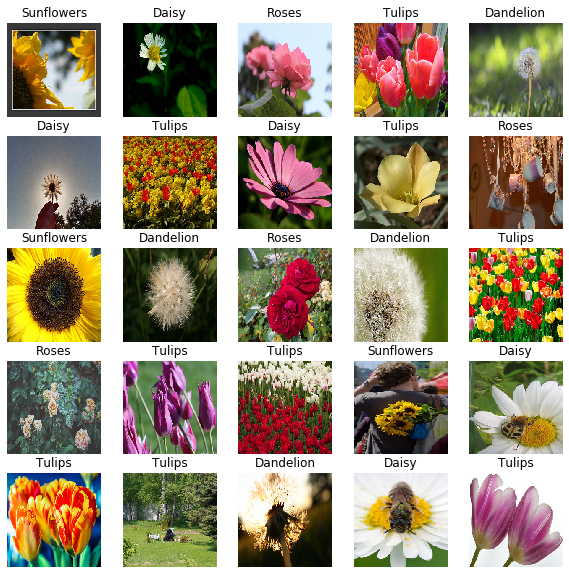

In [22]:
# Here, next() function returns the next item in an iterator.
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## Load using `tf.data`

The above `keras.preprocessing` method is convienient, but has three downsides: 

1. It's slow. See the performance section below.
1. It lacks fine-grained control.
1. It is not well integrated with the rest of TensorFlow.

To load the files as a `tf.data.Dataset` first create a dataset of the file paths:

In [23]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [24]:
# Here, .take() method return elements from array along the mentioned axis and indices.
for f in list_ds.take(5):
  print(f.numpy())

b'/home/fahim/.keras/datasets/flower_photos/dandelion/6897671808_57230e04c5_n.jpg'
b'/home/fahim/.keras/datasets/flower_photos/daisy/2346726545_2ebce2b2a6.jpg'
b'/home/fahim/.keras/datasets/flower_photos/sunflowers/6145005439_ef6e07f9c6_n.jpg'
b'/home/fahim/.keras/datasets/flower_photos/tulips/2238626027_058c404b94.jpg'
b'/home/fahim/.keras/datasets/flower_photos/sunflowers/12282924083_fb80aa17d4_n.jpg'


Write a short pure-tensorflow function that converts a file path to an `(img, label)` pair:

### Next Steps:  Basic methods for training

#### Create a dataset

In [25]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. We will use 80% of the images for training, and 20% for validation.

In [26]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [27]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the class_names attribute on these datasets.

In [28]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


#### Visualize the data

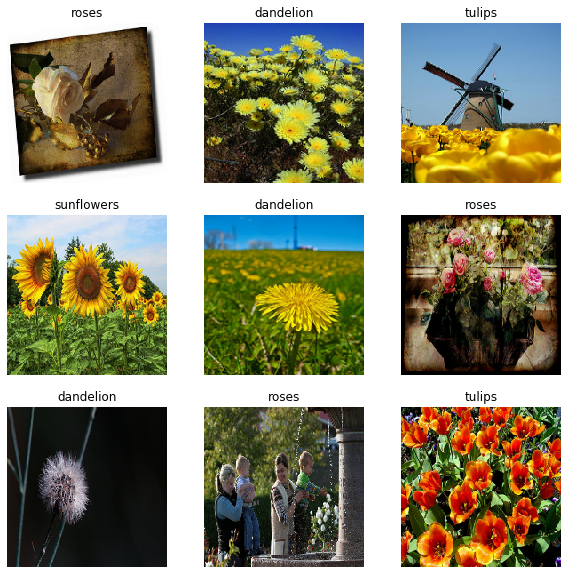

In [29]:
import matplotlib.pyplot as plt
# Here are the first 9 images from the training dataset.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [30]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension referes to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.


#### Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer.

In [31]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [32]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.96902645


#### Configure the dataset for performance
Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

.prefetch() overlaps data preprocessing and model execution while training.

In [33]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Train a model
For completeness, we will show how to train a simple model using the datasets we just prepared. This model has not been tuned in any way - the goal is to show you the mechanics using the datasets you just created. 

In [34]:
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [35]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [36]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 88s 954ms/step - loss: 1.4530 - accuracy: 0.3661 - val_loss: 1.4514 - val_accuracy: 0.3896
Epoch 2/3
92/92 [==============================] - 81s 884ms/step - loss: 1.1087 - accuracy: 0.5334 - val_loss: 1.0224 - val_accuracy: 0.6022
Epoch 3/3
92/92 [==============================] - 81s 880ms/step - loss: 0.9641 - accuracy: 0.6185 - val_loss: 0.9973 - val_accuracy: 0.6035


You may notice the validation accuracy is low to the compared to the training accuracy, indicating our model is overfitting. 

#### Using tf.data for finer control
The above keras.preprocessing utilities are a convenient way to create a tf.data.Dataset from a directory of images. For finer grain control, you can write your own input pipeline using tf.data. This section shows how to do just that, beginning with the file paths from the zip we downloaded earlier.

In [37]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [38]:
for f in list_ds.take(5):
  print(f.numpy())

b'/home/fahim/.keras/datasets/flower_photos/dandelion/494108764_e00178af6e.jpg'
b'/home/fahim/.keras/datasets/flower_photos/sunflowers/2443921986_d4582c123a.jpg'
b'/home/fahim/.keras/datasets/flower_photos/roses/2423565102_2f1a00bb1b_n.jpg'
b'/home/fahim/.keras/datasets/flower_photos/roses/16691277899_9433f39155_n.jpg'
b'/home/fahim/.keras/datasets/flower_photos/tulips/6931748252_68f06086b3.jpg'


The tree structure of the files can be used to compile a class_names list.

In [39]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Split the dataset into train and validation:

In [40]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [41]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


Write a short function that converts a file path to an (img, label) pair:

In [42]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the labe
  return tf.argmax(one_hot)

In [43]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [44]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use Dataset.map to create a dataset of image, label pairs:

In [45]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [46]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


#### Configure dataset for performance
To train a model with this dataset you will want the data:

To be well shuffled.
To be batched.
Batches to be available as soon as possible.
These features can be added using the tf.data API. 

In [47]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

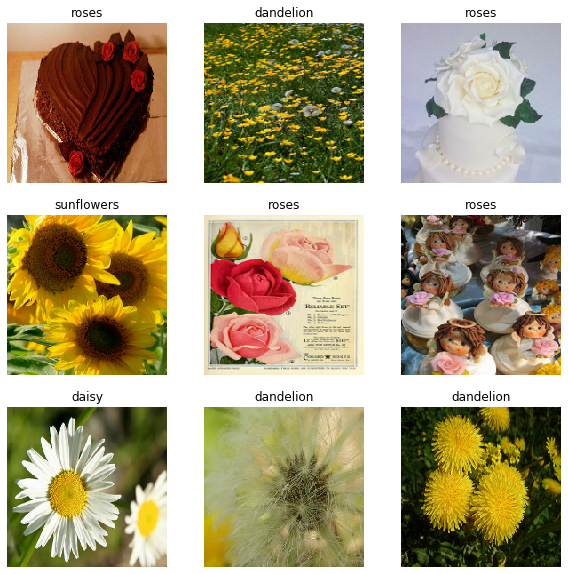

In [48]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

#### Continue training the model
You have now manually built a similar tf.data.Dataset to the one created by the keras.preprocessing above. You can continue training the model with it. As before, we will train for just a few epochs to keep the running time short.

In [49]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 100s 1s/step - loss: 0.8491 - accuracy: 0.6768 - val_loss: 0.8207 - val_accuracy: 0.6703
Epoch 2/3
92/92 [==============================] - 100s 1s/step - loss: 0.6977 - accuracy: 0.7384 - val_loss: 0.7981 - val_accuracy: 0.6907
Epoch 3/3
92/92 [==============================] - 95s 1s/step - loss: 0.5216 - accuracy: 0.8062 - val_loss: 0.7871 - val_accuracy: 0.6935
